## Use GLM to Predict Change in Cases

We are interested in using the existing cases and other information to predict the upcoming change in cases. 

We use H2O implementation to perform Linear Regression on the time series data. In this setup, we attempt to use first $n$ days of data to predict the 3-day change in the number of cases following the training period, i.e. change in case from day $n$ to day $n+3$.

The training data includes:

- Weather information
- Population
- Mobility
- Number of cases and deaths in the training period

Training data is on the county level with the first $n$ days of data averaged to create the observation by county. We found 7-day training data, i.e. $n=7$, to be the most appropriate amount of training data used for prediction the change in the number of cases in the following 3 days. 

Instead of creating one large regression that attempts to capture all data points, we create rolling 7-day periods based on the number of days since the first day of more than ten cases, and we train the model to predict the change of cases from day 7 to day 10 using information from all counties' day 1 to day 7 data. Therefore, in the GLM results, we present the coefficient estimates along with the group of `start dates` the training data falls in.

In [1]:
import sys
sys.path.append('../.')

import datetime
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from lib import get_data
from lib import simplified_model

rc('text', usetex=False)

../lib
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,2 days 1 hour 44 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,1 month and 18 days
H2O cluster name:,H2O_from_python_tcai_1f2d4e
H2O cluster total nodes:,1
H2O cluster free memory:,15.92 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [2]:
def prepare_model_data(date_range, pred_day, outcome):
    df = get_data.get_model_data(date_range=date_range, pred_day=pred_day)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    df_x = simplified_model.multicollinearity_check(
        df.drop([f'day_{pred_day}_delta_cases', f'day_{pred_day}_delta_deaths', 'state', 'county', 'fips'], axis=1))
    df_x = df_x.rename({'deaths': 'past_deaths', 'cases': 'past_cases'}, axis=1)

    df_y = df[[f'day_{pred_day}_delta_{outcome}']]
    df_y = df_y.rename({f'day_{pred_day}_delta_{outcome}': outcome}, axis=1)
    df_model = pd.concat([df_x, df_y], axis=1)

    return df_model

In [3]:
# Model training
model_start_time = datetime.datetime.now().strftime('%m_%d_%H_%M')  # as a flag to track separate model results

periods = 30  # total number of days to try in each period
prediction_period = 3
output_df = pd.DataFrame()

# model by start days to show changing predictability over time
for training_range in tqdm([7]):  # range of dates used for training data, from 4 days of training to 20 days
    mae = {'cases': [], 'deaths': []}  # todo outcome try actual n cases
    for day in range(periods):
        date_range = (day, day + training_range)  # interval controls the length of data collected
        y_day = day + training_range + prediction_period  # currently only predict results from n days out
        print('---', date_range, y_day)

        for y in ['cases', 'deaths']:
            # outcome = f'day_{y_day}_delta_{y}'
            tmp_df = prepare_model_data(date_range, y_day, y)

            if len(tmp_df) <= 200:
                continue

            tmp_output_df = simplified_model.linear(prepare_model_data(date_range, y_day, y),
                                                    outcome=y, family='gaussian', link='identity', seed=1,
                                                    model_name=f'{date_range[0]}_{date_range[1]}_{y_day}',
                                                    suffix=model_start_time)

            try:
                mae[y].append(list(set(tmp_output_df['mae']))[0])
                tmp_output_df['start_date'] = date_range[0]
                tmp_output_df['end_date'] = date_range[1]
                tmp_output_df['interval'] = training_range
                tmp_output_df['pred_date'] = y_day
                tmp_output_df['outcome_name'] = y
                output_df = output_df.append(tmp_output_df)
            except TypeError:
                print('--- No longer predictive')
                break

  0%|          | 0/1 [00:00<?, ?it/s]

--- (0, 7) 10
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
--- (1, 8) 11
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
--- (17, 24) 27
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
--- (18, 25) 28
Parse progress: |█████████████████████████████████████████████████████████| 1

100%|██████████| 1/1 [12:37<00:00, 757.27s/it]


In [4]:
output_df.to_csv(f'../reports/model_coef_{model_start_time}.csv', index=False)

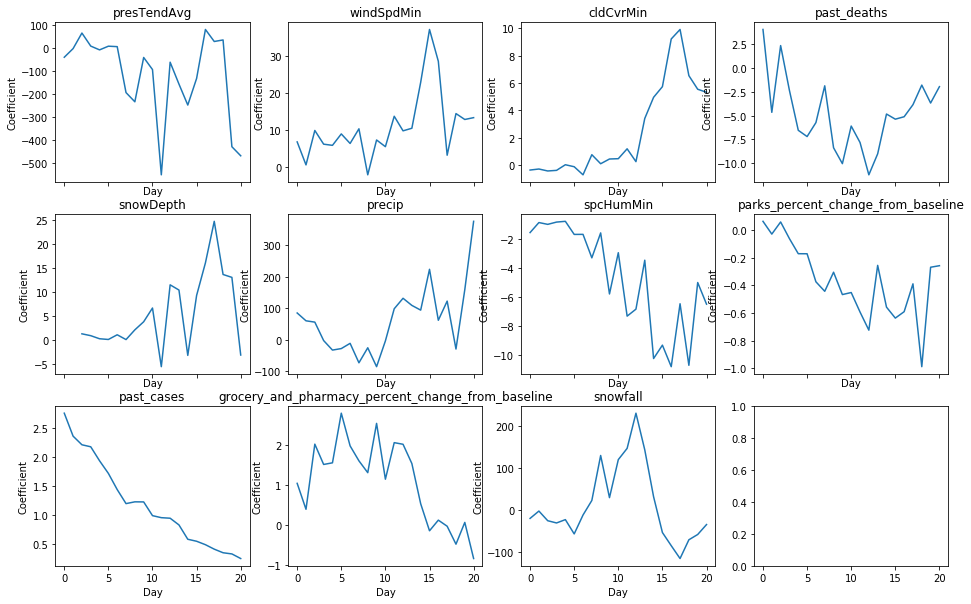

In [5]:
y = 'cases'
tmp_output_df = output_df[output_df['outcome_name'] == y]
n_variables = len(set(tmp_output_df['names']))
fig, axes = plt.subplots(int(np.ceil(n_variables / 4)), 4, figsize=(16, 10), sharex='all')

i = 0
for c in set(tmp_output_df['names']):
    axes[i // 4, i % 4].plot(tmp_output_df[tmp_output_df['names'] == c]['start_date'],
                             tmp_output_df[tmp_output_df['names'] == c]['coefficients'])
    axes[i // 4, i % 4].set_title(f'{c}')
    axes[i // 4, i % 4].set_ylabel('Coefficient')
    axes[i // 4, i % 4].set_xlabel('Day')
    i += 1

plt.show()

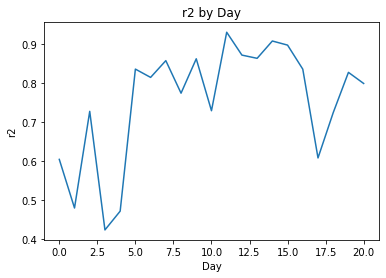

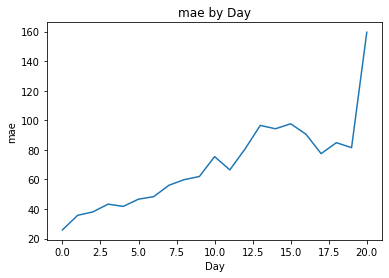

In [6]:
# performance plots
for metric in ['r2', 'mae']:
    performance_df = output_df[['start_date', 'r2', 'mae', 'outcome_name']].drop_duplicates()
    tmp_performance_df = performance_df[performance_df['outcome_name'] == y]
    plt.plot(tmp_performance_df['start_date'], tmp_performance_df[metric])
    plt.title(f'{metric} by Day')
    plt.xlabel('Day')
    plt.ylabel(metric)
    plt.show()

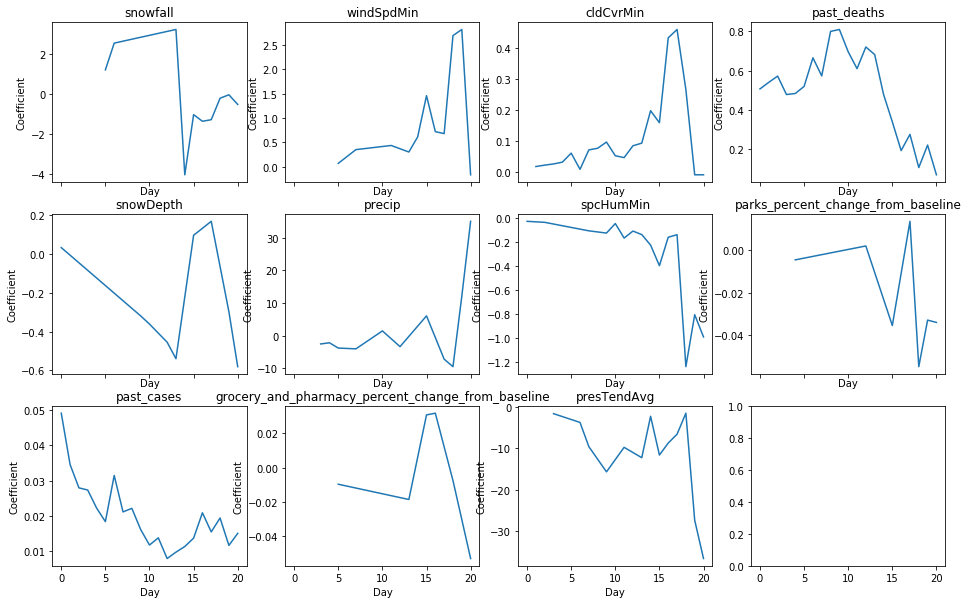

In [7]:
# coefficient plots
y = 'deaths'
tmp_output_df = output_df[output_df['outcome_name'] == y]
n_variables = len(set(tmp_output_df['names']))
fig, axes = plt.subplots(int(np.ceil(n_variables / 4)), 4, figsize=(16, 10), sharex='all')

i = 0
for c in set(tmp_output_df['names']):
    axes[i // 4, i % 4].plot(tmp_output_df[tmp_output_df['names'] == c]['start_date'],
                             tmp_output_df[tmp_output_df['names'] == c]['coefficients'])
    axes[i // 4, i % 4].set_title(f'{c}')
    axes[i // 4, i % 4].set_ylabel('Coefficient')
    axes[i // 4, i % 4].set_xlabel('Day')
    i += 1

plt.show()

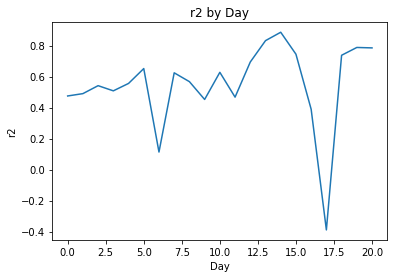

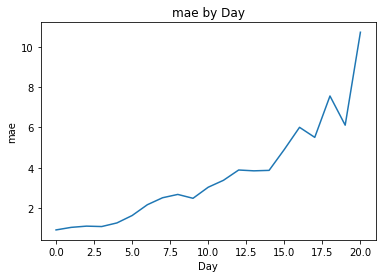

In [8]:
# performance plots
for metric in ['r2', 'mae']:
    performance_df = output_df[['start_date', 'r2', 'mae', 'outcome_name']].drop_duplicates()
    tmp_performance_df = performance_df[performance_df['outcome_name'] == y]
    plt.plot(tmp_performance_df['start_date'], tmp_performance_df[metric])
    plt.title(f'{metric} by Day')
    plt.xlabel('Day')
    plt.ylabel(metric)
    plt.show()

## GAM

Overlay returned figures.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535 entries, 1 to 1153
Data columns (total 14 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   past_cases                                         535 non-null    float64
 1   past_deaths                                        535 non-null    float64
 2   cldCvrMin                                          535 non-null    float64
 3   precip                                             535 non-null    float64
 4   presTendAvg                                        535 non-null    float64
 5   radSolarMin                                        535 non-null    float64
 6   snowDepth                                          535 non-null    float64
 7   snowfall                                           535 non-null    float64
 8   spcHumMin                                          535 non-null    float64
 9   windSpdMi

100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


2.053372048424327


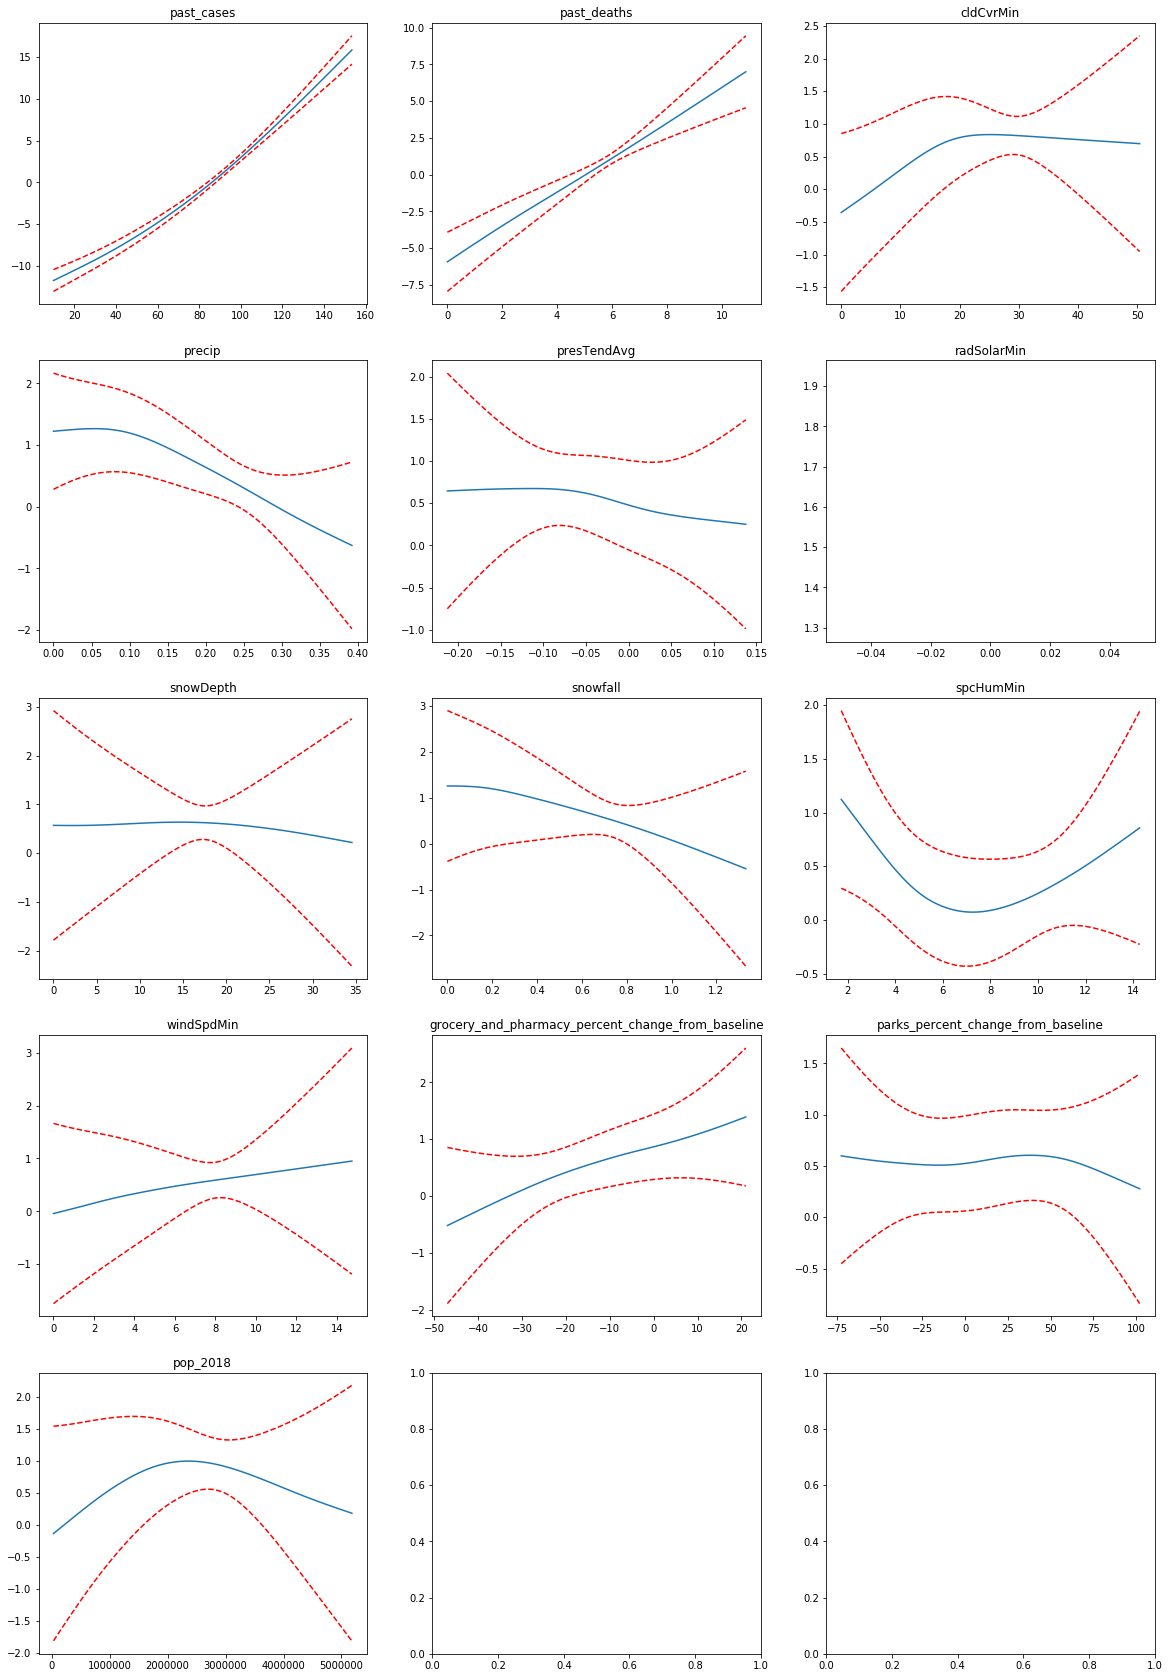

In [9]:
# try gam
fig = simplified_model.linear_gam(prepare_model_data((0, 7), 14, 'deaths'), 'deaths', seed=1)
plt.show()